In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, dummy, metrics
import pickle

print(pd.__version__) #1.1.3
print(np.__version__) #1.19.4
print(sns.__version__) #0.11.0
print(matplotlib.__version__) # 3.3.2
print(sklearn.__version__) # 0.23.2

1.1.3
1.19.4
0.11.0
3.3.2
0.23.2


# Récupération des données

In [2]:
data = pd.read_csv("data/train_resampled.csv")
cat_features = pickle.load(open("pickle_cat_features.pkl", "rb"))

BETA = 2

# Isolation de la cible et séparation des données (train, test)

In [3]:
X = data.drop(columns=['TARGET','Unnamed: 0'])
y = data["TARGET"]
cat_features_index = np.where(X.columns.isin(cat_features))

del data
gc.collect()

39

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=123)

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

del X, y
gc.collect()

X_train : (311128, 676)
X_test : (77782, 676)
y_train : (311128,)
y_test : (77782,)


20

# Etablissement d'une baseline

In [5]:
%%time
# dummy classifier 
dummy_classifier = dummy.DummyClassifier(strategy="stratified", random_state=123)
dummy_classifier.fit(X_train,y_train)

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 11 ms


DummyClassifier(random_state=123, strategy='stratified')

In [6]:
# performances
y_pred = dummy_classifier.predict_proba(X_test)[:, 1]
baseline = metrics.fbeta_score(y_test, y_pred, beta=BETA)
print(f"Baseline F_beta par dummy classifier  : {baseline}")

del dummy_classifier
gc.collect()

Baseline F_beta par dummy classifier  : 0.4985233313644419


40

# Entraînement d'un classifieur LightGBM sur le train set sur 5 folds (5 classifieurs)

In [7]:
# rectification des noms des features pour le classifieur LGBM

def replace_name(name):
    for c in ["[","]",",","{","}",'"',":"," "]:
        if c in name :
            name = name.replace(c,"_")
    return name
            
features = list(map(replace_name, X_train.columns))
X_train.columns = features
X_test.columns = features

In [8]:
# métrique F_beta

def f_beta(y_true, probas_pred):
    y_pred = np.vectorize(lambda x : 0 if x<0.5 else 1)(probas_pred)
    score = metrics.fbeta_score(y_true, y_pred, beta=BETA)
    return "F_beta", score, True

In [9]:
%%time
# modèle de cross validation pour entraînement par fold
folds = model_selection.StratifiedKFold(n_splits= 5, shuffle=True, random_state=123)

# création des dataframes pour stocker les résultats
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # paramètres déterminés par optimisation Bayésienne
    clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=39,
        colsample_bytree=0.18704675203879897,
        subsample=0.9261485670593478,
        max_depth=6,
        reg_alpha=0.8470633083206642,
        reg_lambda=0.5740182739981458,
        min_split_gain=0.0848793956471949,
        min_child_weight=31.190087127061712,
        silent=-1,
        verbose=-1,
        random_state=123,
        categorical_feature=list(cat_features_index[0]))
    
    
    # entraînement de chaque fold
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric=f_beta, verbose= 200, early_stopping_rounds= 200)

    # stockage des prédictions
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    # stockage des features importances
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    _, score, _ = f_beta(valid_y, oof_preds[valid_idx])
    print('Fold %2d F_beta : %.6f' % (n_fold + 1, score))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()


/home/samuel/.local/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.246479	training's F_beta: 0.897027	valid_1's binary_logloss: 0.24765	valid_1's F_beta: 0.89685
[400]	training's binary_logloss: 0.185126	training's F_beta: 0.903951	valid_1's binary_logloss: 0.188776	valid_1's F_beta: 0.90343
[600]	training's binary_logloss: 0.167706	training's F_beta: 0.908712	valid_1's binary_logloss: 0.174912	valid_1's F_beta: 0.906873
[800]	training's binary_logloss: 0.158114	training's F_beta: 0.911579	valid_1's binary_logloss: 0.168912	valid_1's F_beta: 0.908373
[1000]	training's binary_logloss: 0.15165	training's F_beta: 0.914124	valid_1's binary_logloss: 0.166038	valid_1's F_beta: 0.909159
[1200]	training's binary_logloss: 0.146464	training's F_beta: 0.91621	valid_1's binary_logloss: 0.164329	valid_1's F_beta: 0.909615
[1400]	training's binary_logloss: 0.142065	training's F_beta: 0.918158	valid_1's binary_logloss: 0.163216	valid_1's F_beta: 0.91013
[1600]	training's

[2200]	training's binary_logloss: 0.128144	training's F_beta: 0.924391	valid_1's binary_logloss: 0.162373	valid_1's F_beta: 0.90991
[2400]	training's binary_logloss: 0.12516	training's F_beta: 0.925911	valid_1's binary_logloss: 0.16202	valid_1's F_beta: 0.910436
[2600]	training's binary_logloss: 0.122525	training's F_beta: 0.927326	valid_1's binary_logloss: 0.161808	valid_1's F_beta: 0.910398
[2800]	training's binary_logloss: 0.119894	training's F_beta: 0.928593	valid_1's binary_logloss: 0.161577	valid_1's F_beta: 0.910558
[3000]	training's binary_logloss: 0.11734	training's F_beta: 0.930145	valid_1's binary_logloss: 0.161498	valid_1's F_beta: 0.91074
[3200]	training's binary_logloss: 0.114837	training's F_beta: 0.931642	valid_1's binary_logloss: 0.161339	valid_1's F_beta: 0.910561
Early stopping, best iteration is:
[3008]	training's binary_logloss: 0.117235	training's F_beta: 0.930214	valid_1's binary_logloss: 0.161493	valid_1's F_beta: 0.910787
Fold  4 F_beta : 0.910787
Training unti

In [10]:
# affichage des performances

_, train_score, _ = f_beta(y_train, oof_preds)
_, test_score, _ = f_beta(y_test, sub_preds)
print(f"F_beta sur train set  : {train_score}")
print(f"F_beta sur test set : {test_score}")

F_beta sur train set  : 0.9109224527852201
F_beta sur test set : 0.9120626030516371


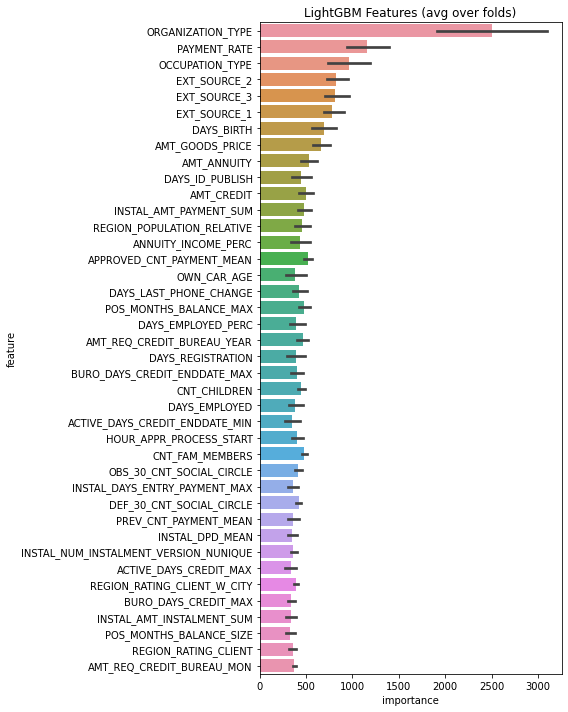

In [11]:
# affichage de l'importance des features

cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean()\
                    .sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('img/lgbm_importances01.png')

# Entraînement d'un LGBM Classifier unique sur le train set

In [12]:
# création d'un set de validation

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_train, y_train, test_size=0.2, 
                                                                      random_state=123)

In [13]:
%%time
# modèle avec les mêmes paramètres

clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,        
        learning_rate=0.02,
        num_leaves=39,
        colsample_bytree=0.18704675203879897,
        subsample=0.9261485670593478,
        max_depth=6,
        reg_alpha=0.8470633083206642,
        reg_lambda=0.5740182739981458,
        min_split_gain=0.0848793956471949,
        min_child_weight=31.190087127061712,
        silent=-1,
        verbose=-1,
        random_state=123,
        categorical_feature=list(cat_features_index[0]))

# entraînement
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    eval_metric=f_beta, verbose= 200, early_stopping_rounds= 200)

/home/samuel/.local/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.24521	training's F_beta: 0.897418	valid_1's binary_logloss: 0.247287	valid_1's F_beta: 0.898231
[400]	training's binary_logloss: 0.184794	training's F_beta: 0.904374	valid_1's binary_logloss: 0.189511	valid_1's F_beta: 0.904825
[600]	training's binary_logloss: 0.167466	training's F_beta: 0.908785	valid_1's binary_logloss: 0.175561	valid_1's F_beta: 0.907366
[800]	training's binary_logloss: 0.157884	training's F_beta: 0.911885	valid_1's binary_logloss: 0.169433	valid_1's F_beta: 0.908571
[1000]	training's binary_logloss: 0.15153	training's F_beta: 0.91426	valid_1's binary_logloss: 0.166484	valid_1's F_beta: 0.909103
[1200]	training's binary_logloss: 0.146625	training's F_beta: 0.916402	valid_1's binary_logloss: 0.164712	valid_1's F_beta: 0.90953
[1400]	training's binary_logloss: 0.142216	training's F_beta: 0.918108	valid_1's binary_logloss: 0.163539	valid_1's F_beta: 0.909987
[1600]	training

LGBMClassifier(categorical_feature=[0, 1, 2, 3, 9, 10, 11, 12, 13, 20, 21, 22,
                                    23, 24, 25, 26, 30, 38, 84, 85, 87, 88, 94,
                                    95, 96, 97, 98, 99, 100, 101, ...],
               colsample_bytree=0.18704675203879897, learning_rate=0.02,
               max_depth=6, min_child_weight=31.190087127061712,
               min_split_gain=0.0848793956471949, n_estimators=10000,
               num_leaves=39, random_state=123, reg_alpha=0.8470633083206642,
               reg_lambda=0.5740182739981458, silent=-1,
               subsample=0.9261485670593478, verbose=-1)

In [14]:
# performances

y_pred = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1]
f_beta(y_test, y_pred)

('F_beta', 0.9121570351298597, True)

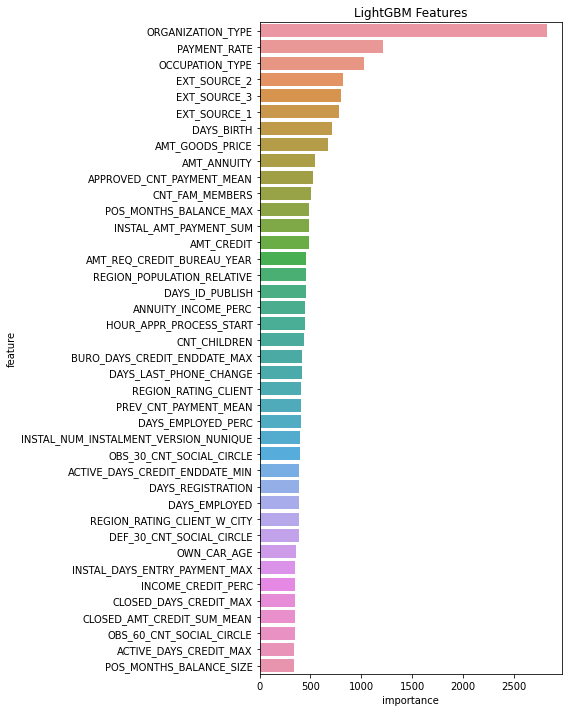

In [15]:
# features importances

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns
feature_importance_df["importance"] = clf.feature_importances_
best_features_idx = feature_importance_df.sort_values(by="importance", ascending=False)[:40].index
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=feature_importance_df.iloc[best_features_idx].sort_values(by="importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()

Les performances sont à peine moins bonnes, je garde donc ce principe d'un classifieur unique.


In [16]:
# AUROC du modèle

print(metrics.roc_auc_score(y_test, y_pred))


0.9771061227094684


Seuil 0.1 f-beta-score 0.9226421448757559
Seuil 0.11 f-beta-score 0.9246610656361556
Seuil 0.12000000000000001 f-beta-score 0.9264688462449656
Seuil 0.13 f-beta-score 0.9280057916685261
Seuil 0.14 f-beta-score 0.929529633207517
Seuil 0.15000000000000002 f-beta-score 0.9301529045871376
Seuil 0.16 f-beta-score 0.9310130328781692
Seuil 0.17 f-beta-score 0.9310874050218889
Seuil 0.18 f-beta-score 0.931387391751953
Seuil 0.19 f-beta-score 0.9315285415791845
Seuil 0.2 f-beta-score 0.9312987164468246
Seuil 0.21000000000000002 f-beta-score 0.931163287086446
Seuil 0.22 f-beta-score 0.9308448337322403
Seuil 0.23 f-beta-score 0.9304330965793126
Seuil 0.24000000000000002 f-beta-score 0.9301273663981682
Seuil 0.25 f-beta-score 0.9296295917113725


Text(0, 0.5, 'F-beta-score')

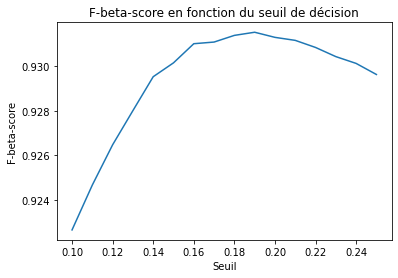

In [17]:
# recherche du seuil optimisant le f_beta

scores = list()
thresolds = np.linspace(0.1, 0.25, 16)

for thres in np.linspace(0.1, 0.25, 16):
    y_pred_label = [0 if i<=thres else 1 for i in y_pred]
    score = metrics.fbeta_score(y_test, y_pred_label, beta=BETA)
    scores.append(score)
    print(f"Seuil {thres} f-beta-score {score}")
    
sns.lineplot(x=thresolds, y=scores)
plt.title("F-beta-score en fonction du seuil de décision")
plt.xlabel("Seuil")
plt.ylabel("F-beta-score")

              precision    recall  f1-score   support

         0.0     0.9434    0.8556    0.8974     38874
         1.0     0.8680    0.9487    0.9066     38908

    accuracy                         0.9022     77782
   macro avg     0.9057    0.9022    0.9020     77782
weighted avg     0.9057    0.9022    0.9020     77782

[[33262  5612]
 [ 1996 36912]]


<AxesSubplot:>

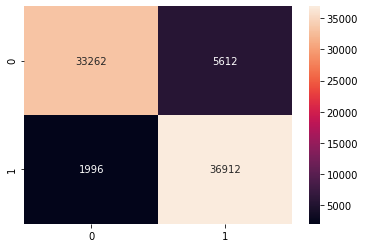

In [18]:
# rapport de performances 

thres = 0.18
y_pred_label = [0 if i<=thres else 1 for i in y_pred]
print(metrics.classification_report(y_test, y_pred_label, digits=4))
conf_matrix = metrics.confusion_matrix(y_test, y_pred_label)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt="d")
